In [1]:
# -*- encode=utf-8 -*-
"""
    此模型是z-hack算法比赛的另外一个模型，使用RNN进行训练和预测
"""
import tensorflow as tf
from tensorflow.python.keras.layers import Dense, RNN, Layer
from tensorflow.python.keras import backend as K
from tensorflow.python.keras import Input, activations
from tensorflow.python.keras.models import Sequential, Model, load_model
from tensorflow.python.keras.utils import multi_gpu_model
import pandas as pd
import numpy as np

In [2]:
class MinimalRNNCell(Layer):

    def __init__(self, units=32, activation="tanh", **kwargs):
        self.units = units
        self.state_size = units
        self.activation = activation
        super(MinimalRNNCell, self).__init__(**kwargs)

    def build(self, input_shape):
        self.kernel = self.add_weight(shape=(input_shape[-1], self.units),
                                      initializer='uniform',
                                      name='kernel')
        self.recurrent_kernel = self.add_weight(
            shape=(self.units, self.units),
            initializer='uniform',
            name='recurrent_kernel')
        self.built = True

    def call(self, inputs, states):
        prev_output = states[0]
        h = K.dot(inputs, self.kernel)
        output = h + K.dot(prev_output, self.recurrent_kernel)
        activation = activations.get(self.activation)
        output = activation(output)
        return output, [output]

In [3]:
class BuildModel():

    def __init__(self):
        self.TIMESTEP = 20
        self.DATA_DIM = 1
        self.model = None
        self.rnnLayer = None
        self.input = None
        self.output = None
        self.x_train = None
        self.y_train = None
        self.history = None
        self.filename = r"../../data/all_part"
        self.original_data = pd.read_csv(self.filename, sep="\t")

    def __get_data(self):
        x = []
        y = []
        data = self.original_data.iloc[:, -1].values
        for i in range(len(data) - self.TIMESTEP):
            x.append(data[i:i + self.TIMESTEP])
            y.append(data[i + self.TIMESTEP])
        x = np.asarray(x, dtype=np.float32)
        x = x / x.max()
        y = np.asarray(y, dtype=np.float32)
        y = y / y.max()
        self.x_train = x.reshape([x.shape[0], x.shape[1], 1])
        self.y_train = y.reshape([y.shape[0], 1])
        self.input = Input(shape=(20, 1), name="input_tensor")

    def __built_multi_cell_Layer(self):
        """
        :return: the output tensor.
        """
        o1 = RNN(MinimalRNNCell(32, "tanh"), return_sequences=True)(self.input)
        o2 = RNN(MinimalRNNCell(32, "tanh"), return_sequences=True)(o1)
        o3 = RNN(MinimalRNNCell(32, "tanh"), return_sequences=True)(o2)
        o4 = RNN(MinimalRNNCell(32, "tanh"), return_sequences=False)(o3)
        o5 = Dense(1, activation="tanh")(o4)
        self.output = o5

    def build_model(self):
        if self.input is None:
            self.__get_data()
        if self.rnnLayer is None:
            self.rnnLayer = self.__built_multi_cell_Layer()

        if self.model is None:
            try:
                self.model = load_model("model_sec.h5",custom_objects={"MinimalRNNCell":MinimalRNNCell})
                print(self.model.summary())
                history = self.model.fit(self.x_train, self.y_train, 20, 50, 1, validation_split=0.2)
                self.model.save("./model_zec.hdf5")
                return history
            except:
                self.model = Model(inputs=self.input, outputs=self.output)
                self.model.compile("adam", loss="mse", metrics=["mae"])
                print(self.model.summary())
                history = self.model.fit(self.x_train, self.y_train, 20, 50, 2, validation_split=0.2)
                self.model.save("./model_sec.h5")
                return history


In [4]:
mymodel = BuildModel()
history = mymodel.build_model()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_tensor (InputLayer)    (None, 20, 1)             0         
_________________________________________________________________
rnn (RNN)                    (None, 20, 32)            1056      
_________________________________________________________________
rnn_1 (RNN)                  (None, 20, 32)            2048      
_________________________________________________________________
rnn_2 (RNN)                  (None, 20, 32)            2048      
_________________________________________________________________
rnn_3 (RNN)                  (None, 32)                2048      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 7,233
Trainable params: 7,233
Non-trainable params: 0
_________________________________________________________________
None
Tra

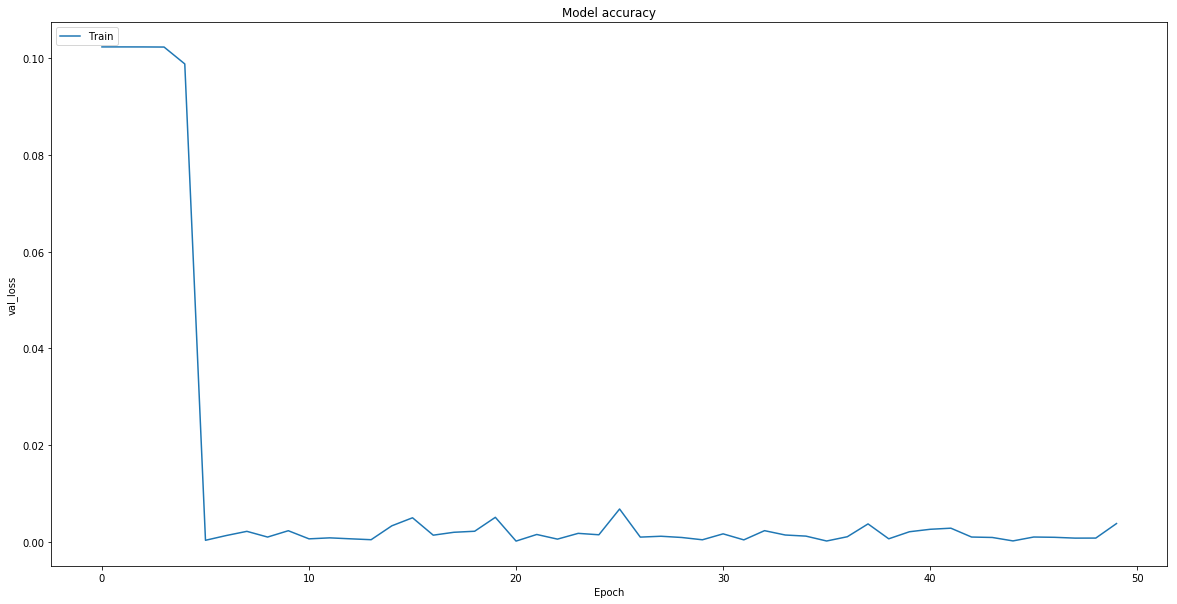

In [8]:
import matplotlib.pylab as plt
plt.figure(figsize=(20, 10))
plt.plot(history.history['val_loss'])
plt.title('Model accuracy')
plt.ylabel('val_loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

### RETRAIN MODEL

In [15]:
orig_model = load_model("./model_sec.h5", custom_objects={"MinimalRNNCell":MinimalRNNCell})
history2 = orig_model.fit(mymodel.x_train, mymodel.y_train, nb_epoch=50, verbose=1, validation_split=0.2, batch_size=20)
orig_model.save("./model_thir.h5")

Train on 973 samples, validate on 244 samples
Epoch 1/50
973/973 [==============================] - 5s 5ms/step - loss: 0.0028 - mean_absolute_error: 0.0443 - val_loss: 0.0012 - val_mean_absolute_error: 0.0335
Epoch 2/50
973/973 [==============================] - 4s 4ms/step - loss: 0.0027 - mean_absolute_error: 0.0440 - val_loss: 0.0018 - val_mean_absolute_error: 0.0410
Epoch 3/50
973/973 [==============================] - 4s 4ms/step - loss: 0.0026 - mean_absolute_error: 0.0432 - val_loss: 0.0014 - val_mean_absolute_error: 0.0367
Epoch 4/50
973/973 [==============================] - 4s 4ms/step - loss: 0.0025 - mean_absolute_error: 0.0430 - val_loss: 6.9023e-04 - val_mean_absolute_error: 0.0250
Epoch 5/50
973/973 [==============================] - 4s 4ms/step - loss: 0.0029 - mean_absolute_error: 0.0450 - val_loss: 0.0017 - val_mean_absolute_error: 0.0409
Epoch 6/50
973/973 [==============================] - 4s 4ms/step - loss: 0.0027 - mean_absolute_error: 0.0429 - val_loss: 0.0012 

In [16]:
history.history.keys()

dict_keys(['val_loss', 'val_mean_absolute_error', 'loss', 'mean_absolute_error'])

In [17]:
val_mean_absolute_error = history.history['val_mean_absolute_error']

In [20]:
val_mean_absolute_error = np.asarray(val_mean_absolute_error, dtype=np.float32)

In [21]:
val_mean_absolute_error2 = np.asarray(history2.history['val_mean_absolute_error'], dtype=np.float32)

In [22]:
val_mean_absolute_error2.shape

(50,)

In [24]:
all_val_mean_error = np.append(val_mean_absolute_error, val_mean_absolute_error2)

In [25]:
all_val_mean_error.shape

(100,)

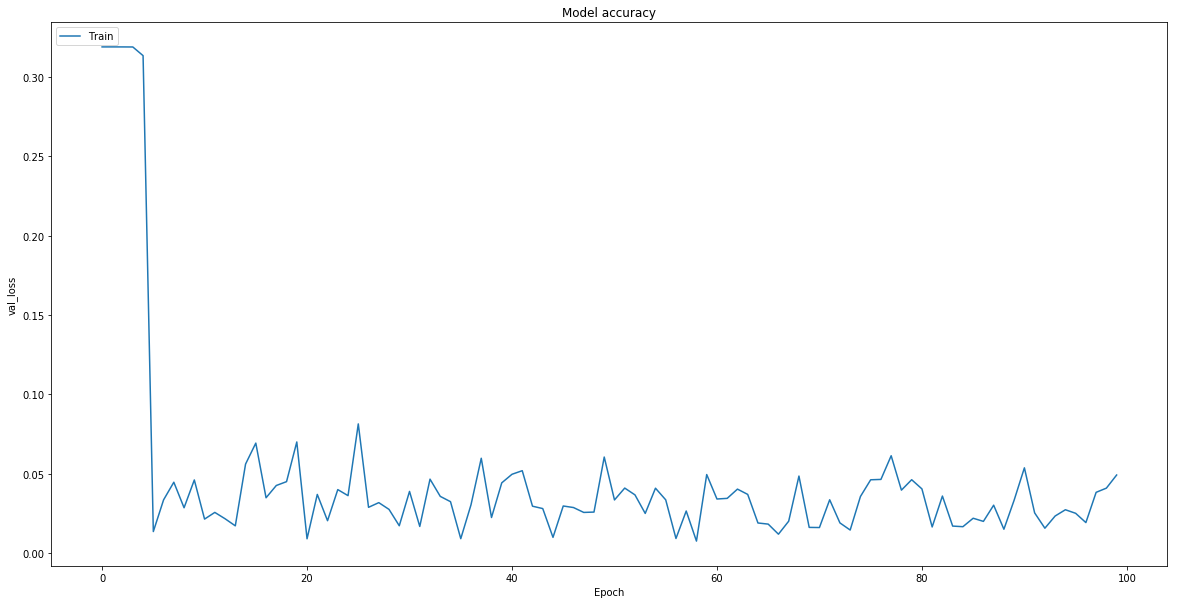

In [26]:
plt.figure(figsize=(20, 10))
plt.plot(all_val_mean_error)
plt.title('Model accuracy')
plt.ylabel('val_loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

### Third Train

In [27]:
orig_model = load_model("./model_thir.h5", custom_objects={"MinimalRNNCell":MinimalRNNCell})
history3 = orig_model.fit(mymodel.x_train, mymodel.y_train, nb_epoch=1000, verbose=0, validation_split=0.2, batch_size=50)
orig_model.save("./model_forth.h5")

In [28]:
all_val_mean_error = np.append(all_val_mean_error, history3.history['val_mean_absolute_error'])

In [29]:
all_val_mean_error.shape

(1100,)

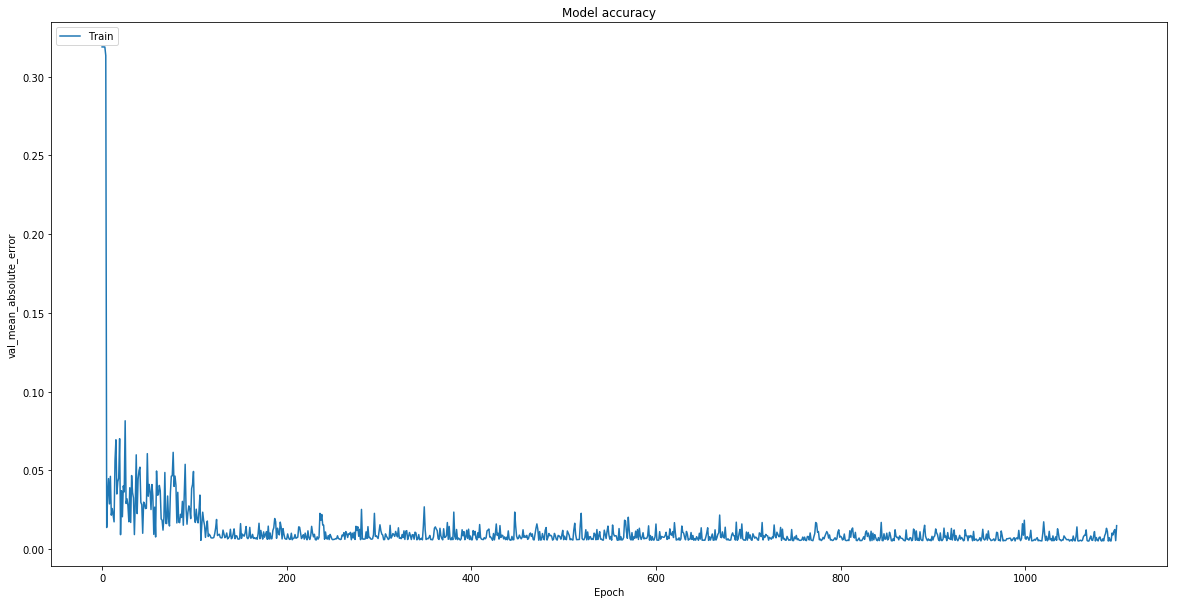

In [30]:
plt.figure(figsize=(20, 10))
plt.plot(all_val_mean_error)
plt.title('Model accuracy')
plt.ylabel('val_mean_absolute_error')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [31]:
orig_model = load_model("./model_forth.h5", custom_objects={"MinimalRNNCell":MinimalRNNCell})
history4 = orig_model.fit(mymodel.x_train, mymodel.y_train, nb_epoch=900, verbose=0, validation_split=0.2, batch_size=50)
orig_model.save("./model_fifth.h5")

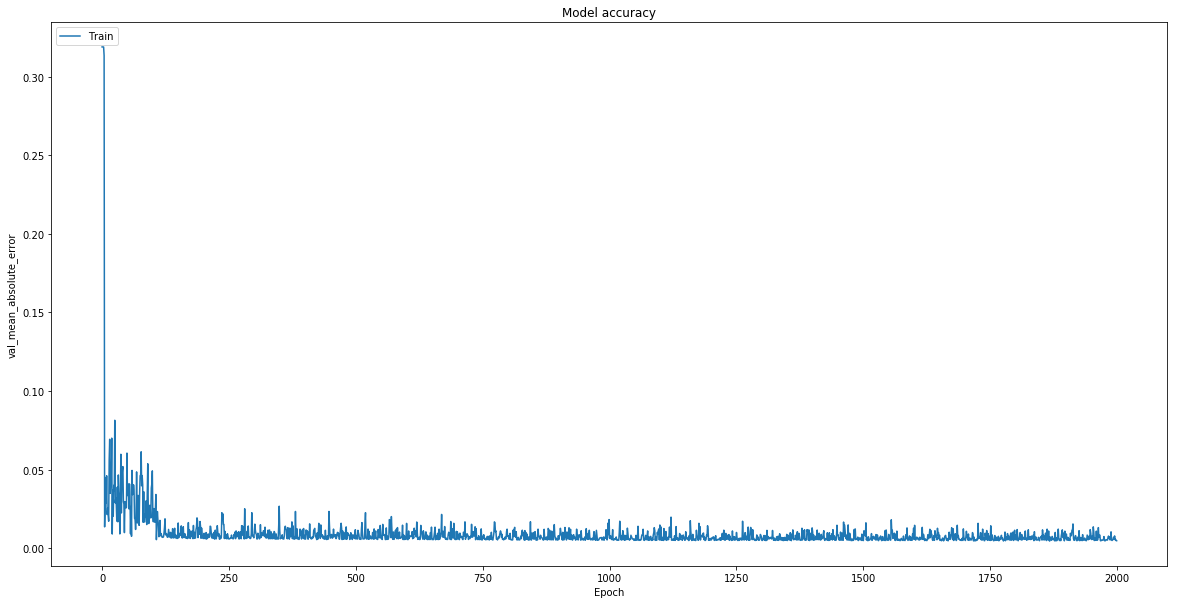

In [32]:
all_val_mean_error = np.append(all_val_mean_error, history4.history['val_mean_absolute_error'])
plt.figure(figsize=(20, 10))
plt.plot(all_val_mean_error)
plt.title('Model accuracy')
plt.ylabel('val_mean_absolute_error')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper left')
plt.show()

In [33]:
type(all_val_mean_error)

numpy.ndarray

In [34]:
np.save("loss_error_value.npy", all_val_mean_error)

In [35]:
value = np.load("./loss_error_value.npy")

In [36]:
value.shape

(2000,)